### Chunking Analysis

**How to use this notebook?** - Upload your text files that you want to test. There are multiple sections in the notebook; if you want to jump to a specific topic, you can go there directly. I’d recommend trying all the approaches one by one before starting your next project. 😄 It hardly takes 10 minutes to run this notebook completely. All the best!

The text files I used while writing the code can be found [here](https://drive.google.com/drive/folders/180vPqIVhQHiK5pQNbJc0TcEvfNZJckpT?usp=sharing). You don't need to download them separately. I have written code to download the text files automatically.

Found something interesting? - DM me on [Linkedin](https://linkedin.com/in/shresthshuklaji)

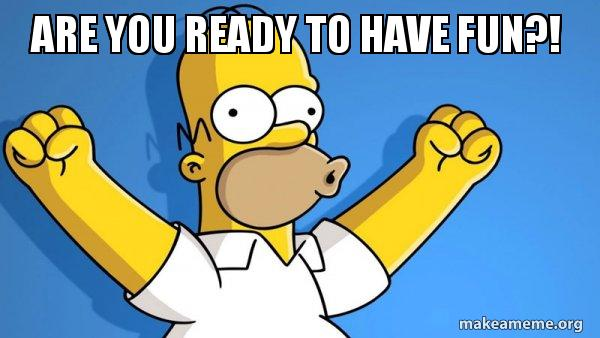

#### Install Libraries and Files

In [ ]:
# Dictionary of file links. You can get the URLs from the drive link above too. There are file IDs.
language_files = {
    "spanish": "1nNMVoTHpluFHBJeKXx5SQlLLAWBILxiT",
    "english": "1WJSKMIh8Cum926alhlS8-XhlnrTEq_zL",
    "hindi": "1sh9Zzrc4Xji3LAZEs8-czOy_FgPON8Sg",
    "french": "1Io9A-lHBluwxDnzaVqJ107ziCJKD-9pM",
}


# Downloading each file and saving as text files
for lang, file_id in language_files.items():
    !wget -O {lang}.txt """https://drive.google.com/uc?export=download&id={file_id}"""

--2025-01-14 05:55:05--  https://drive.google.com/uc?export=download&id=1nNMVoTHpluFHBJeKXx5SQlLLAWBILxiT
Resolving drive.google.com (drive.google.com)... 142.250.101.102, 142.250.101.101, 142.250.101.139, ...
Connecting to drive.google.com (drive.google.com)|142.250.101.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1nNMVoTHpluFHBJeKXx5SQlLLAWBILxiT&export=download [following]
--2025-01-14 05:55:05--  https://drive.usercontent.google.com/download?id=1nNMVoTHpluFHBJeKXx5SQlLLAWBILxiT&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.137.132, 2607:f8b0:4023:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.137.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12098 (12K) [application/octet-stream]
Saving to: ‘spanish.txt’

spanish.txt         100%[===================>]  11.81K  --.-KB/s  

11794


In [ ]:
with open("/content/english.txt", "r") as file:
    english_text = file.read()

with open("/content/hindi.txt", "r") as file:
    hindi_text = file.read()

with open("/content/french.txt", "r") as file:
    french_text = file.read()

with open("/content/spanish.txt", "r") as file:
    spanish_text = file.read()


print(len(english_text))
print(len(hindi_text))
print(len(french_text))
print(len(spanish_text))

11145
11805
12512
11794


In [ ]:
# Install required packages
!pip install langchain
!pip install langchain_community
!pip install langchain_huggingface
!pip install lancedb
!pip install sentence-transformers
!pip install transformers
!pip install tqdm
!pip install seaborn
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install torch
!pip install accelerate
!pip install langchain_experimental
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of lancedb to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.9/29.9 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.7 MB/s eta 0:00:00


In [ ]:
import os
from typing import List, Dict, Any, Tuple
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain.schema import Document
import lancedb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import nltk

nltk.download("punkt_tab")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
def process_text(
    text: str,
    chunk_sizes: List[int],
    model_name: str = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    db_path: str = "/content/lancedb_data",
    language: str = "text",
) -> Dict:
    """
    Process a single text into chunks of different sizes and store in LanceDB

    Args:
        text: Text content to process
        chunk_sizes: List of chunk sizes to try
        model_name: Name of the embedding model
        db_path: Path to LanceDB database
        language: Language identifier for table names

    Returns:
        Dictionary containing processed data information
    """
    # Initialize
    embeddings = HuggingFaceEmbeddings(model_name=model_name)
    db = lancedb.connect(db_path)
    processed_data = {}

    # Preprocess text
    text = text.replace("\n", " ")

    print(f"Processing text into different chunk sizes...")
    for chunk_size in chunk_sizes:
        print(f"\nCreating chunks of size {chunk_size}")

        # Create chunks
        splitter = RecursiveCharacterTextSplitter(
            chunk_size=chunk_size, chunk_overlap=50
        )
        chunks = splitter.create_documents([text])
        chunk_texts = [chunk.page_content for chunk in chunks]

        # Get embeddings from HF model
        print(f"Generating embeddings for {len(chunks)} chunks...")
        embeddings_list = embeddings.embed_documents(chunk_texts)

        # Store in LanceDB. For each language and for that specific chunk we'll create a single table and store all chunks there.
        table_name = f"{language}_chunks_{chunk_size}"
        df = pd.DataFrame(
            {
                "text": chunk_texts,
                "vector": embeddings_list,
                "chunk_index": range(len(chunks)),
                "char_length": [len(chunk) for chunk in chunk_texts],
            }
        )

        db.create_table(
            table_name, data=df, mode="overwrite"
        )  # table with same name will be overwritten when we rerun the query over another text.

        print(f"Created {len(chunks)} chunks")
        print(f"Average chunk length: {df['char_length'].mean():.2f} characters")

        # Store metadata
        processed_data[chunk_size] = {
            "num_chunks": len(chunks),
            "table_name": table_name,
            "avg_length": df["char_length"].mean(),
        }

    return processed_data

In [ ]:
english_data = process_text(
    text=english_text, chunk_sizes=[100, 200, 300, 400], language="en"
)

hindi_data = process_text(
    text=hindi_text, chunk_sizes=[100, 200, 300, 400], language="hi"
)

french_data = process_text(
    text=french_text, chunk_sizes=[100, 200, 300, 400], language="fr"
)


spanish_data = process_text(
    text=spanish_text, chunk_sizes=[100, 200, 300, 400], language="es"
)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Processing text into different chunk sizes...

Creating chunks of size 100
Generating embeddings for 227 chunks...
Created 227 chunks
Average chunk length: 94.65 characters

Creating chunks of size 200
Generating embeddings for 75 chunks...
Created 75 chunks
Average chunk length: 192.84 characters

Creating chunks of size 300
Generating embeddings for 45 chunks...
Created 45 chunks
Average chunk length: 291.44 characters

Creating chunks of size 400
Generating embeddings for 32 chunks...
Created 32 chunks
Average chunk length: 391.56 characters
Processing text into different chunk sizes...

Creating chunks of size 100
Generating embeddings for 236 chunks...
Created 236 chunks
Average chunk length: 95.95 characters

Creating chunks of size 200
Generating embeddings for 79 chunks...
Created 79 chunks
Average chunk length: 194.89 characters

Creating chunks of size 300
Generating embeddings for 48 chunks...
Created 48 chunks
Average chunk length: 291.46 characters

Creating chunks of size

#### Create Embeddings, Store them into LanceDB and Visualize Chunks

{100: {'avg_length': 94.65198237885463,
       'num_chunks': 227,
       'table_name': 'en_chunks_100'},
 200: {'avg_length': 192.84, 'num_chunks': 75, 'table_name': 'en_chunks_200'},
 300: {'avg_length': 291.44444444444446,
       'num_chunks': 45,
       'table_name': 'en_chunks_300'},
 400: {'avg_length': 391.5625, 'num_chunks': 32, 'table_name': 'en_chunks_400'}}



{100: {'avg_length': 95.95338983050847,
       'num_chunks': 236,
       'table_name': 'hi_chunks_100'},
 200: {'avg_length': 194.8860759493671,
       'num_chunks': 79,
       'table_name': 'hi_chunks_200'},
 300: {'avg_length': 291.4583333333333,
       'num_chunks': 48,
       'table_name': 'hi_chunks_300'},
 400: {'avg_length': 392.2647058823529,
       'num_chunks': 34,
       'table_name': 'hi_chunks_400'}}



{100: {'avg_length': 94.6600790513834,
       'num_chunks': 253,
       'table_name': 'fr_chunks_100'},
 200: {'avg_length': 193.17857142857142,
       'num_chunks': 84,
       'table_name': 'fr_chunks_200'}

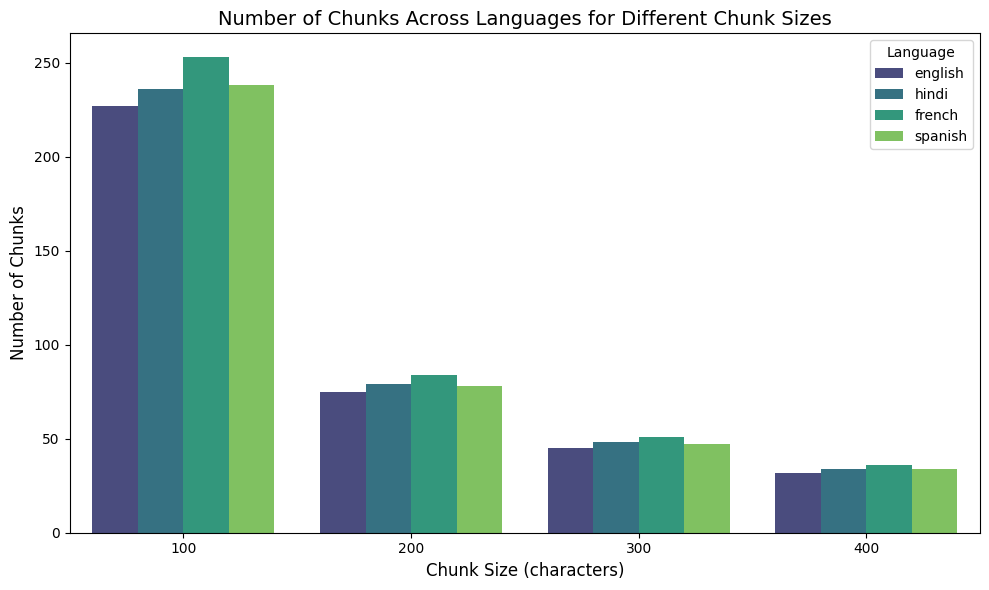

In [ ]:
from pprint import pprint

pprint(english_data)
print("\n\n")
pprint(hindi_data)
print("\n\n")
pprint(french_data)
print("\n\n")
pprint(spanish_data)


data = {
    "english": english_data,
    "hindi": hindi_data,
    "french": french_data,
    "spanish": spanish_data,
}

visual_data = []
for language, chunk_info in data.items():
    for chunk_size, stats in chunk_info.items():
        visual_data.append(
            {
                "Language": language,
                "Chunk Size": chunk_size,
                "Number of Chunks": stats["num_chunks"],
            }
        )

df = pd.DataFrame(visual_data)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df, x="Chunk Size", y="Number of Chunks", hue="Language", palette="viridis"
)
plt.title("Number of Chunks Across Languages for Different Chunk Sizes", fontsize=14)
plt.xlabel("Chunk Size (characters)", fontsize=12)
plt.ylabel("Number of Chunks", fontsize=12)
plt.legend(title="Language")
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
def search_chunks(
    query: str,
    chunk_size: int,
    language: str = "text",
    model_name: str = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    db_path: str = "/content/lancedb_data",
    top_k: int = 3,
) -> Dict:
    """
    Search chunks for a given query

    Args:
        query: Query string to search
        chunk_size: Chunk size to search in
        language: Language identifier for the tables to search upon
        model_name: Name of the embedding model
        db_path: Path to LanceDB database
        top_k: Number of results to return

    Returns:
        Dictionary containing search results and metrics
    """

    # Initialize
    embeddings = HuggingFaceEmbeddings(model_name=model_name)
    db = lancedb.connect(db_path)

    # Get query embedding
    print(f"Processing query: '{query}'")
    query_embedding = embeddings.embed_query(query)

    # Search in LanceDB
    table_name = f"{language}_chunks_{chunk_size}"
    table = db.open_table(table_name)
    results = table.search(query_embedding).metric("cosine").limit(top_k).to_pandas()

    # Calculate similarity scores
    similarities = 1 - results["_distance"].values

    # Prepare results
    search_results = {
        "texts": results["text"].tolist(),
        "similarity_scores": similarities.tolist(),
        "char_lengths": results["char_length"].tolist(),
        "query": query,
        "chunk_size": chunk_size,
        "avg_similarity": np.mean(similarities),
    }

    print(f"\nResults for chunk size {chunk_size}:")
    print(f"Average similarity score: {search_results['avg_similarity']:.4f}")
    for i, (text, score) in enumerate(
        zip(search_results["texts"], search_results["similarity_scores"])
    ):
        print(f"\nResult {i+1} (similarity: {score:.4f}):")
        print(f"Text snippet (limited to 200 characters): {text[:200]}...")

    return search_results


def compare_chunk_sizes(
    query: str,
    chunk_sizes: List[int],
    language: str = "text",
    model_name: str = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    db_path: str = "/content/lancedb_data",
    top_k: int = 3,
) -> Dict:
    """
    Compare search results across different chunk sizes

    Args:
        query: Query string
        chunk_sizes: List of chunk sizes to compare
        language: Language identifier
        model_name: Name of the embedding model
        db_path: Path to LanceDB database
        top_k: Number of results to return per chunk size

    Returns:
        Dictionary containing comparison results
    """
    comparison = {}

    for chunk_size in chunk_sizes:
        results = search_chunks(
            query=query,
            chunk_size=chunk_size,
            language=language,
            model_name=model_name,
            db_path=db_path,
            top_k=top_k,
        )
        comparison[chunk_size] = results

    return comparison

In [ ]:
# Search with a query for a specific chunk size. note that change chunk size in this cell and run other two cells to visualize the results.


hi_results = search_chunks(query="एजीआई क्या है?", chunk_size=400, language="hi")


# print(hi_results)
en_results = search_chunks(query="What is AGI?", chunk_size=400, language="en")
# print(en_results)

es_results = search_chunks(query="¿Qué es AGI?", chunk_size=400, language="es")
# print(es_results)

fr_results = search_chunks(query="Qu'est-ce que l'AGI?", chunk_size=400, language="fr")
# print(fr_results)

Processing query: 'एजीआई क्या है?'

Results for chunk size 400:
Average similarity score: 0.5622

Result 1 (similarity: 0.6552):
Text snippet (limited to 200 characters): कृत्रिम सामान्य बुद्धिमत्ता (AGI) उस प्रकार की एआई को संदर्भित करती है जो किसी भी बौद्धिक कार्य को करने में सक्षम हो, जो एक मानव कर सकता है। संकीर्ण एआई के विपरीत, जिसे विशिष्ट कार्यों के लिए डिज़ाइन ...

Result 2 (similarity: 0.5243):
Text snippet (limited to 200 characters): के मार्गदर्शन में मदद मिलेगी।   आर्टिफिशियल जनरल इंटेलिजेंस: प्रौद्योगिकी में एक नया मोड़ हम एक तकनीकी क्रांति के कगार पर खड़े हैं, और आर्टिफिशियल जनरल इंटेलिजेंस (AGI) केवल एक विकास नहीं है, बल्कि यह...

Result 3 (similarity: 0.5071):
Text snippet (limited to 200 characters): को संबोधित करने के लिए AI संरेखण और मूल्य लोडिंग जैसे अवधारणाओं का पता लगाया जा रहा है।      एजीआई को प्रोत्साहित करने वाले तकनीकी नवाचार   1. न्यूरल नेटवर्क और उन्नत आर्किटेक्चर एजीआई (AGI) के विकास ...
Processing query: 'What is AGI?'

Results for chunk size 400:
Average

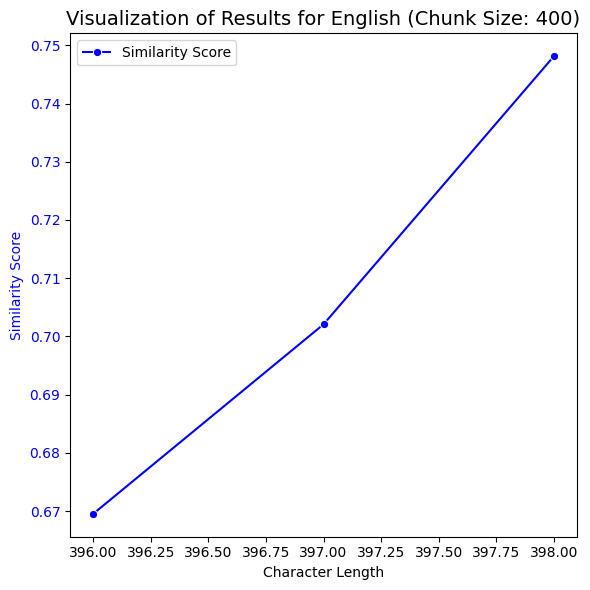

Query: What is AGI?
Average Similarity: 0.71


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# code to visualize results for single language and chunk size
def visualize_results(results, language):
    """
    Visualizes the similarity scores and chunk lengths for a given language.

    Args:
        results (dict): Dictionary containing 'texts', 'similarity_scores', 'char_lengths', 'query', 'chunk_size', 'avg_similarity'.
        language (str): Name of the language for labeling purposes.
    """
    # Prepare DataFrame for visualization
    data = {
        "Character Length": results["char_lengths"],
        "Similarity Score": results["similarity_scores"],
    }
    df = pd.DataFrame(data)

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))

    # Plot similarity scores
    sns.lineplot(
        data=df,
        x="Character Length",
        y="Similarity Score",
        marker="o",
        ax=ax,
        color="blue",
        label="Similarity Score",
    )
    ax.set_ylabel("Similarity Score", color="blue")
    ax.set_xlabel("Character Length")
    ax.tick_params(axis="y", labelcolor="blue")

    # Add title and labels
    plt.title(
        f"Visualization of Results for {language} (Chunk Size: {results['chunk_size']})",
        fontsize=14,
    )
    plt.tight_layout()

    # Display plot
    plt.show()

    # Print query and average similarity
    print(f"Query: {results['query']}")
    print(f"Average Similarity: {results['avg_similarity']:.2f}")


visualize_results(en_results, "English")

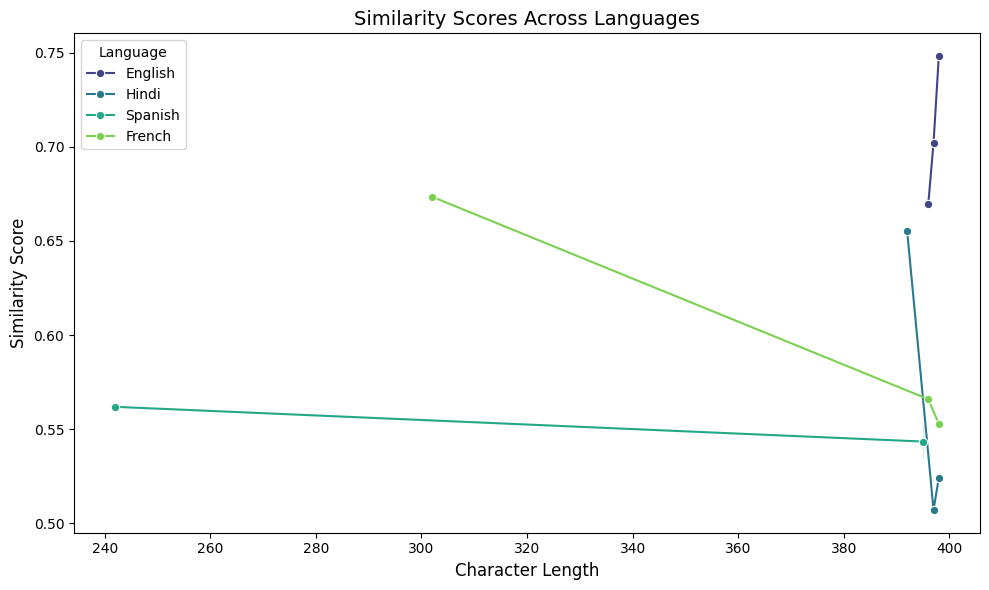

In [ ]:
def visualize_combined_results(results_dict):
    """
    Visualizes similarity scores across multiple languages in a single plot.

    Args:
        results_dict (dict): A dictionary where keys are language names and values are the results dictionaries.
    """
    # Combine data from all languages
    combined_data = []
    for language, results in results_dict.items():
        for i in range(len(results["texts"])):
            combined_data.append(
                {
                    "Character Length": results["char_lengths"][i],
                    "Similarity Score": results["similarity_scores"][i],
                    "Language": language,
                }
            )

    # Create DataFrame
    df = pd.DataFrame(combined_data)

    # Plot combined data
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=df,
        x="Character Length",
        y="Similarity Score",
        hue="Language",
        marker="o",
        palette="viridis",
    )

    # Customize plot
    plt.title("Similarity Scores Across Languages", fontsize=14)
    plt.xlabel("Character Length", fontsize=12)
    plt.ylabel("Similarity Score", fontsize=12)
    plt.legend(title="Language", fontsize=10)
    plt.tight_layout()

    # Show plot
    plt.show()


result_dict = {
    "English": en_results,
    "Hindi": hi_results,
    "Spanish": es_results,
    "French": fr_results,
}

visualize_combined_results(result_dict)

In [ ]:
from pprint import pprint

pprint(es_results)

{'avg_similarity': 0.54963,
 'char_lengths': [242, 395, 395],
 'chunk_size': 400,
 'query': '¿Qué es AGI?',
 'similarity_scores': [0.561918318271637,
                       0.5523564219474792,
                       0.5346153378486633],
 'texts': ['de la capacidad de la humanidad para innovar de manera '
           'responsable. A medida que avanzamos, la colaboración, la '
           'regulación y un sentido compartido de responsabilidad serán '
           'esenciales para garantizar que AGI sirva como una fuerza para el '
           'bien.',
           'El desarrollo de AGI es tanto emocionante como desafiante. Sus '
           'recompensas incluyen resolver los desafíos más complejos de la '
           'humanidad, desde erradicar enfermedades hasta abordar el cambio '
           'climático. Sin embargo, sus riesgos—pérdida de privacidad, dilemas '
           'éticos y uso indebido potencial—no pueden ignorarse.  El camino '
           'hacia la AGI es una prueba de la capacidad de l

In [ ]:
query_h = "एजीआई क्या है?"
query_e = "What is AGI?"
query_s = "¿Qué es AGI?"
query_f = "Qu'est-ce que l'AGI?"

comparison_results_h = compare_chunk_sizes(
    query_h, chunk_sizes=[100, 200, 300, 400], language="hi"
)
comparison_results_e = compare_chunk_sizes(
    query_e, chunk_sizes=[100, 200, 300, 400], language="en"
)
comparison_results_s = compare_chunk_sizes(
    query_s, chunk_sizes=[100, 200, 300, 400], language="es"
)
comparison_results_f = compare_chunk_sizes(
    query_f, chunk_sizes=[100, 200, 300, 400], language="fr"
)

Processing query: 'एजीआई क्या है?'

Results for chunk size 100:
Average similarity score: 0.6034

Result 1 (similarity: 0.6548):
Text snippet (limited to 200 characters): कृत्रिम सामान्य बुद्धिमत्ता (AGI) उस प्रकार की एआई को संदर्भित करती है जो किसी भी बौद्धिक कार्य को...

Result 2 (similarity: 0.5913):
Text snippet (limited to 200 characters): है। संकीर्ण एआई (Narrow AI), जो भाषा अनुवाद, छवि पहचान, या गेम खेलने जैसे विशिष्ट कार्यों के लिए...

Result 3 (similarity: 0.5640):
Text snippet (limited to 200 characters): के साथ मेल खाता है? इस मुद्दे को संबोधित करने के लिए AI संरेखण और मूल्य लोडिंग जैसे अवधारणाओं का...
Processing query: 'एजीआई क्या है?'

Results for chunk size 200:
Average similarity score: 0.5963

Result 1 (similarity: 0.6531):
Text snippet (limited to 200 characters): कृत्रिम सामान्य बुद्धिमत्ता (AGI) उस प्रकार की एआई को संदर्भित करती है जो किसी भी बौद्धिक कार्य को करने में सक्षम हो, जो एक मानव कर सकता है। संकीर्ण एआई के विपरीत, जिसे विशिष्ट कार्यों के लिए डिज़ाइन...

Resu

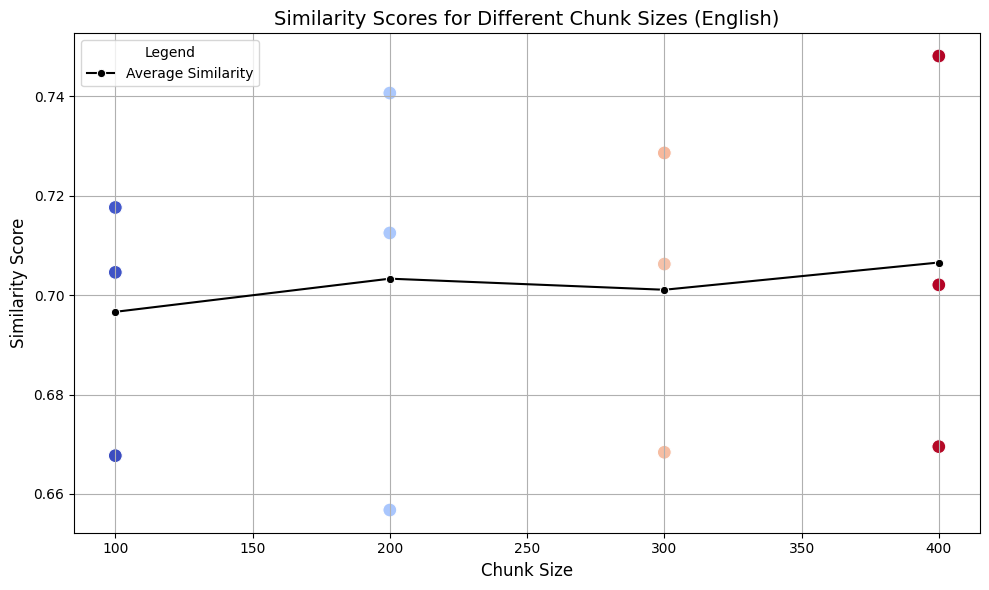

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def visualize_chunk_comparison(results, language):
    """
    Visualizes the comparison of similarity scores and average similarity across chunk sizes.

    Args:
        results (dict): Dictionary containing results for different chunk sizes.
        language (str): Name of the language for labeling purposes.
    """
    # Prepare data for visualization
    data = []
    for chunk_size, details in results.items():
        for i, similarity in enumerate(details["similarity_scores"]):
            data.append(
                {
                    "Chunk Size": chunk_size,
                    "Similarity Score": similarity,
                    "Character Length": details["char_lengths"][i],
                }
            )
        # Add average similarity for the chunk size
        data.append(
            {
                "Chunk Size": chunk_size,
                "Similarity Score": details["avg_similarity"],
                "Character Length": "Average",
            }
        )

    df = pd.DataFrame(data)

    # Separate average and individual chunk points
    avg_df = df[df["Character Length"] == "Average"]
    chunk_df = df[df["Character Length"] != "Average"]

    # Plot individual chunk similarities
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=chunk_df,
        x="Chunk Size",
        y="Similarity Score",
        hue="Character Length",
        palette="coolwarm",
        s=100,
        legend=False,
    )

    # Plot average similarity
    sns.lineplot(
        data=avg_df,
        x="Chunk Size",
        y="Similarity Score",
        marker="o",
        color="black",
        label="Average Similarity",
    )

    # Customize plot
    plt.title(f"Similarity Scores for Different Chunk Sizes ({language})", fontsize=14)
    plt.xlabel("Chunk Size", fontsize=12)
    plt.ylabel("Similarity Score", fontsize=12)
    plt.legend(title="Legend", fontsize=10)
    plt.grid(True)
    plt.tight_layout()

    # Show plot
    plt.show()


# Visualize Results for single language - Hindi/English/Spanish/French
# visualize_chunk_comparison(comparison_results_h, "Hindi")


visualize_chunk_comparison(comparison_results_e, "English")
# visualize_chunk_comparison(comparison_results_s, "Spanish")
# visualize_chunk_comparison(comparison_results_f, "French")

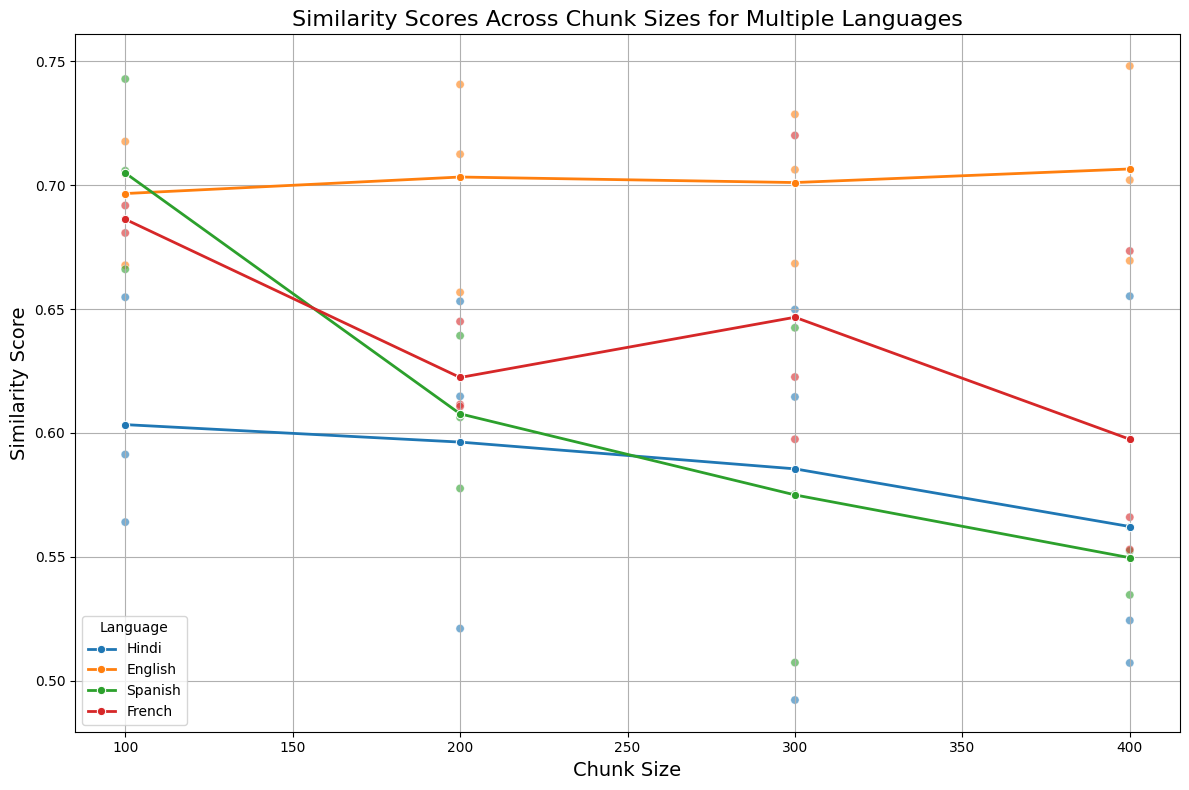

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# code to visualize combined retrieval results
def visualize_combined_chunk_comparison(results_dict):
    """
    Visualizes the comparison of similarity scores across chunk sizes for multiple languages in a single plot.

    Args:
        results_dict (dict): A dictionary where keys are language names and values are results dictionaries.
    """
    # Prepare data for all languages
    combined_data = []
    for language, results in results_dict.items():
        for chunk_size, details in results.items():
            # Add individual chunk scores
            for i, similarity in enumerate(details["similarity_scores"]):
                combined_data.append(
                    {
                        "Language": language,
                        "Chunk Size": chunk_size,
                        "Similarity Score": similarity,
                        "Type": "Chunk Score",
                    }
                )
            # Add average similarity for the chunk size
            combined_data.append(
                {
                    "Language": language,
                    "Chunk Size": chunk_size,
                    "Similarity Score": details["avg_similarity"],
                    "Type": "Average Similarity",
                }
            )

    # Create DataFrame
    df = pd.DataFrame(combined_data)

    # Plot combined data
    plt.figure(figsize=(12, 8))
    sns.lineplot(
        data=df[df["Type"] == "Average Similarity"],
        x="Chunk Size",
        y="Similarity Score",
        hue="Language",
        marker="o",
        palette="tab10",
        linewidth=2,
    )
    sns.scatterplot(
        data=df[df["Type"] == "Chunk Score"],
        x="Chunk Size",
        y="Similarity Score",
        hue="Language",
        palette="tab10",
        alpha=0.6,
        legend=False,
    )

    # Customize plot
    plt.title(
        "Similarity Scores Across Chunk Sizes for Multiple Languages", fontsize=16
    )
    plt.xlabel("Chunk Size", fontsize=14)
    plt.ylabel("Similarity Score", fontsize=14)
    plt.grid(True)
    plt.legend(title="Language", fontsize=10)
    plt.tight_layout()

    # Show plot
    plt.show()


# Visualize Combined Results

comparison_results = {
    "Hindi": comparison_results_h,
    "English": comparison_results_e,
    "Spanish": comparison_results_s,
    "French": comparison_results_f,
}

visualize_combined_chunk_comparison(comparison_results)

#### Other Fixed Character Approaches

In [ ]:
# !pip install tiktoken

In [ ]:
import spacy
from langchain.text_splitter import (
    RecursiveCharacterTextSplitter,
    TokenTextSplitter,
    SpacyTextSplitter,
    NLTKTextSplitter,
    CharacterTextSplitter,
)


def spacy_chunking(text: str, model: str = "en_core_web_sm") -> List[str]:
    nlp = spacy.load(model)
    doc = nlp(text)
    chunks = []
    for sent in doc.sents:
        chunks.append(sent.text.strip())
    return chunks


def token_based_chunking(
    text: str, chunk_size: int = 400, chunk_overlap: int = 50
) -> List[str]:
    splitter = TokenTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    return splitter.split_text(text)


def character_chunking(
    text: str, chunk_size: int = 1000, chunk_overlap: int = 200
) -> List[str]:
    splitter = CharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    return splitter.split_text(text)


spacy_chunks = spacy_chunking(english_text)
token_chunks = token_based_chunking(english_text)


print(len(token_chunks))  # Use appropriate model for language
for i in range(len(token_chunks)):
    pprint(token_chunks[i])
    print("\n\n")

7
('Artificial General Intelligence (AGI) refers to a type of AI capable of '
 'performing any intellectual task that a human can do.\n'
 'Unlike narrow AI, which is designed for specific tasks like language '
 'translation or image recognition, AGI aims to replicate human\n'
 'cognitive abilities such as reasoning, learning, and problem-solving. '
 'Developing AGI is considered one of the biggest challenges\n'
 'in the field of AI, as it requires understanding and mimicking the '
 'complexity of the human brain. AGI could revolutionize industries,\n'
 'from healthcare and education to automation and research. However, it also '
 'raises concerns about ethics, control, and potential misuse.\n'
 '\n'
 'In the pursuit of AGI, researchers face numerous technical hurdles, '
 'including the development of machines that can understand context,\n'
 'apply common sense, and demonstrate creativity. While current AI systems can '
 'excel in highly specialized areas, achieving generalization\n'
 

#### Advanced Chunking 01 - Semantic and Clustering Chunking

In [ ]:
import nltk

nltk.download("punkt_tab")
nltk.download("punkt")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from nltk.tokenize import sent_tokenize

sentences = sent_tokenize(
    english_text, language="english"
)  # change paramters to check how different languages get split into sentences.
print(len(sentences))
for i in sentences:
    print(i)
    print("\n")

87
Artificial General Intelligence (AGI) refers to a type of AI capable of performing any intellectual task that a human can do.


Unlike narrow AI, which is designed for specific tasks like language translation or image recognition, AGI aims to replicate human
cognitive abilities such as reasoning, learning, and problem-solving.


Developing AGI is considered one of the biggest challenges
in the field of AI, as it requires understanding and mimicking the complexity of the human brain.


AGI could revolutionize industries,
from healthcare and education to automation and research.


However, it also raises concerns about ethics, control, and potential misuse.


In the pursuit of AGI, researchers face numerous technical hurdles, including the development of machines that can understand context,
apply common sense, and demonstrate creativity.


While current AI systems can excel in highly specialized areas, achieving generalization
across a wide variety of domains remains a significant ch

In [ ]:
import re
import nltk
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from typing import List


# Initialize the model and ensure nltk data is available
def initialize_model_and_nltk(
    model_name: str = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
) -> SentenceTransformer:
    """
    Initialize the SentenceTransformer model and ensure NLTK tokenizer data is downloaded.
    """

    try:
        nltk.data.find("tokenizers/punkt")
    except LookupError:
        nltk.download("punkt")
    return SentenceTransformer(model_name)


model = initialize_model_and_nltk()

In [ ]:
def split_into_sentences(text: str) -> List[str]:
    """
    Split text into sentences using NLTK. Other three languages handled here since they behave somewhat similar.
    For better results you might need to pass language as parameter.
    """

    from nltk.tokenize import sent_tokenize

    return sent_tokenize(text)


def split_hindi_text(text: str) -> List[str]:
    """
    Split Hindi text into sentences using regex.
    """
    return [
        sentence.strip()
        for sentence in re.split(r"(?<=[।])\s*", text)
        if sentence.strip()
    ]

In [ ]:
def get_embeddings(model: SentenceTransformer, sentences: List[str]) -> np.ndarray:
    """
    Generate embeddings for sentences using the SentenceTransformer model.
    """
    return model.encode(sentences, show_progress_bar=True)

In [ ]:
def determine_optimal_clusters(
    text_length: int,
    num_sentences: int,
    min_chunk_size: int = 100,
    max_chunk_size: int = 2000,
) -> int:
    """
    Determine the optimal number of clusters based on text length and desired chunk sizes.
    """
    avg_chars_per_sentence = text_length / num_sentences
    min_sentences = max(2, min_chunk_size / avg_chars_per_sentence)
    max_sentences = max_chunk_size / avg_chars_per_sentence

    return max(
        2,
        min(
            num_sentences // 2,  # Avoid too many clusters
            int(num_sentences / min_sentences),  # Ensure minimum chunk size
        ),
    )

In [ ]:
def chunk_text(
    model: SentenceTransformer,
    text: str,
    min_chunk_size: int = 100,
    max_chunk_size: int = 2000,
    num_chunks: int = None,
) -> List[str]:
    """
    Split text into semantically coherent chunks.
    """
    # Split text into sentences
    sentences = split_into_sentences(text)

    # Fallback to Hindi splitting if fewer than 3 sentences detected. Writing this since we have already experimented with it.
    if len(sentences) < 3:
        print("splitting hindi text into sentences ")
        sentences = split_hindi_text(text)

    # Generate embeddings
    embeddings = get_embeddings(model, sentences)

    # Determine number of clusters if not provided
    if num_chunks is None:
        num_chunks = determine_optimal_clusters(
            len(text), len(sentences), min_chunk_size, max_chunk_size
        )

    print("Total number of chunks/clusters", num_chunks)

    # Cluster sentences
    kmeans = KMeans(n_clusters=min(num_chunks, len(sentences)), random_state=42)
    clusters = kmeans.fit_predict(embeddings)

    # Sort sentences by cluster and position
    sentence_clusters = [
        (sent, cluster, i) for i, (sent, cluster) in enumerate(zip(sentences, clusters))
    ]
    sentence_clusters.sort(key=lambda x: (x[1], x[2]))

    print("Top 5 sentences in first cluster : ", sentence_clusters[:5])

    # Combine sentences into chunks
    chunks = []
    current_chunk = []
    current_cluster = sentence_clusters[0][1]

    for sentence, cluster, _ in sentence_clusters:
        if cluster != current_cluster:
            chunks.append(" ".join(current_chunk))
            print("Current Cluster - ", current_cluster)
            print("Chunk - ", chunks)
            print("-- -- --")
            current_chunk = []
            current_cluster = cluster

        current_chunk.append(sentence)

    if current_chunk:
        print(current_chunk)
        print("Last Chunks")
        chunks.append(" ".join(current_chunk))
    return chunks

In [ ]:
model = initialize_model_and_nltk()  # you can chose to remove progress bar
text = spanish_text  # change your text here

sentences = split_into_sentences(text)
# sentences = split_hindi_text(text)
print("Initial count of sentences : ", len(sentences))

embeddings = get_embeddings(model, sentences)

num_clusters = determine_optimal_clusters(len(text), len(sentences))

chunks = chunk_text(model, text)

Initial count of sentences :  84


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Total number of chunks/clusters 42
Top 5 sentences in first cluster :  [('Salud: Una Nueva Era de Precisión y Personalización\nLa integración de AGI en el sector de la salud tiene el potencial de transformar radicalmente la atención al paciente y la investigación médica.', 0, 26), ('La dependencia de AGI para decisiones médicas críticas plantea preguntas sobre la responsabilidad.', 0, 31), ('En la búsqueda de la IAG, los investigadores enfrentan numerosos obstáculos técnicos, incluidos el desarrollo de máquinas que puedan comprender el contexto, aplicar el sentido común y demostrar creatividad.', 1, 5), ('Avances clave como el aprendizaje por refuerzo, las redes neuronales y el procesamiento de lenguaje natural nos han acercado a la IAG, pero el viaje sigue siendo largo\ny plagado de desafíos.', 1, 13), ('3.', 2, 39)]
Current Cluster -  0
Chunk -  ['Salud: Una Nueva Era de Precisión y Personalización\nLa integración de AGI en el sector de la salud tiene el potencial de transformar radi

In [ ]:
print(
    "Final count after mixing semantic and clustering Chunking : ", len(chunks), "\n\n"
)
for i in chunks:
    print(len(i), "----", i)
    print("-" * 10)
    print("\n\n")

Final count after mixing semantic and clustering Chunking :  7 


2 ---- 3.
----------



4389 ---- ये वे सवाल हैं जिनका समाधान किया जाना चाहिए क्योंकि AGI अनुसंधान में निरंतर प्रगति हो रही है।

जैसे-जैसे हम भविष्य की ओर बढ़ते हैं, नवाचार और जिम्मेदारी के बीच संतुलन बनाए रखने का महत्व स्पष्ट होता जाता है। जबकि AGI में
अप्रत्याशित वादे हैं, इसके विकास को सतर्कता और इसके समाज पर संभावित प्रभावों की गहरी समझ के साथ किया जाना चाहिए। AGI की
दिशा अभी भी अनिश्चित है, लेकिन इसके सकारात्मक और नकारात्मक दोनों प्रभावों से मानवता के भविष्य के मार्गदर्शन में मदद मिलेगी।

 आर्टिफिशियल जनरल इंटेलिजेंस: प्रौद्योगिकी में एक नया मोड़
हम एक तकनीकी क्रांति के कगार पर खड़े हैं, और आर्टिफिशियल जनरल इंटेलिजेंस (AGI) केवल एक विकास नहीं है, बल्कि यह मनुष्यों और मशीनों के सह-अस्तित्व में एक संपूर्ण परिवर्तन का प्रतीक है। संकीर्ण एआई (Narrow AI), जो भाषा अनुवाद, छवि पहचान, या गेम खेलने जैसे विशिष्ट कार्यों के लिए डिज़ाइन की गई है, के विपरीत, AGI का लक्ष्य मानव जैसी संज्ञानात्मक क्षमताओं की नकल करना है। यह सीखने,

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import numpy as np
from typing import List
import nltk
import re
from nltk.tokenize import sent_tokenize


class SemanticTransformerChunker:
    def __init__(
        self,
        model_name: str = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        min_chunk_size: int = 100,
        max_chunk_size: int = 2000,
        threshold_percentile: int = 90,
    ):
        """
        Initialize the semantic chunker

        Args:
            model_name: Name of the sentence-transformer model to use
            min_chunk_size: Minimum characters per chunk
            max_chunk_size: Maximum characters per chunk
        """
        self.model = SentenceTransformer(model_name)
        self.min_chunk_size = min_chunk_size
        self.max_chunk_size = max_chunk_size

        # Download NLTK data if needed
        try:
            nltk.data.find("tokenizers/punkt")
        except LookupError:
            nltk.download("punkt")

    def split_into_sentences(self, text: str) -> List[str]:
        """Split text into sentences using NLTK"""
        return sent_tokenize(text)

    def split_hindi_text(self, text: str) -> List[str]:
        """Split text into sentences using regex"""
        sentences = re.split(r"(?<=[।])\s*", text)

        # Split sentences using the Danda punctuation. (| for hindi language)

        hindi_sentences = [
            sentence.strip()
            for sentence in re.split(r"(?<=[।])\s*", text)
            if sentence.strip()
        ]
        return hindi_sentences

    def get_embeddings(self, sentences: List[str]) -> np.ndarray:
        """Get embeddings for sentences using sentence-transformer"""
        return self.model.encode(sentences, show_progress_bar=True)

    def determine_optimal_clusters(self, text_length: int, num_sentences: int) -> int:
        """
        Determine optimal number of clusters based on text length
        and desired chunk sizes
        """

        avg_chars_per_sentence = text_length / num_sentences
        min_sentences = max(2, self.min_chunk_size / avg_chars_per_sentence)
        max_sentences = self.max_chunk_size / avg_chars_per_sentence

        return max(
            2,
            min(
                num_sentences // 2,  # Don't create too many clusters
                int(num_sentences / min_sentences),  # Ensure minimum chunk size
            ),
        )

    def chunk_text(self, text: str, num_chunks: int = None) -> List[str]:
        """
        Split text into semantically coherent chunks

        Args:
            text: Input text to chunk. Assuming we only have 4 languages as of now as in starting.
            num_chunks: Optional number of chunks (if not provided, will be calculated)
        Returns:
            List of text chunks
        """

        # Split into sentences (for those 3 languages)
        sentences = self.split_into_sentences(text)

        if len(sentences) < 3:
            sentences = self.split_hindi_text(text)
            print("splitting hindi text into sentences ")

        # Get sentence embeddings
        embeddings = self.get_embeddings(sentences)

        # Determine number of clusters if not provided. it's better to determine this programmatically but we'll see how this might be concerning as well.
        if num_chunks is None:
            num_chunks = self.determine_optimal_clusters(len(text), len(sentences))

        # Cluster sentences -- #if num_chunks given is more than no. of sentences, we'll take count of sentences as clusters.
        kmeans = KMeans(n_clusters=min(num_chunks, len(sentences)), random_state=42)

        clusters = kmeans.fit_predict(embeddings)

        # Sort sentences by cluster and position
        sentence_clusters = [
            (sent, cluster, i)
            for i, (sent, cluster) in enumerate(zip(sentences, clusters))
        ]
        sentence_clusters.sort(key=lambda x: (x[1], x[2]))

        # Combine sentences into chunks
        chunks = []
        current_chunk = []
        current_cluster = sentence_clusters[0][1]

        for sentence, cluster, _ in sentence_clusters:
            if cluster != current_cluster:
                chunks.append(" ".join(current_chunk))
                current_chunk = []
                current_cluster = cluster
            current_chunk.append(sentence)

        if current_chunk:
            chunks.append(" ".join(current_chunk))

        return chunks

    def analyze_chunks(self, chunks: List[str]) -> dict:
        """Analyze the created chunks"""
        lengths = [len(chunk) for chunk in chunks]

        # Get embeddings for each chunk
        chunk_embeddings = self.get_embeddings(chunks)

        # Calculate semantic similarity between consecutive chunks
        similarities = []
        for i in range(len(chunk_embeddings) - 1):
            similarity = np.dot(chunk_embeddings[i], chunk_embeddings[i + 1]) / (
                np.linalg.norm(chunk_embeddings[i])
                * np.linalg.norm(chunk_embeddings[i + 1])
            )
            similarities.append(similarity)

        return {
            "num_chunks": len(chunks),
            "avg_chunk_size": np.mean(lengths),
            "min_chunk_size": min(lengths),
            "max_chunk_size": max(lengths),
            "avg_similarity_between_chunks": (
                np.mean(similarities) if similarities else 0
            ),
            "min_similarity": np.min(similarities) if similarities else 0,
            "max_similarity": np.max(similarities) if similarities else 0,
        }

In [ ]:
def store_embeddings(
    chunks: List[str],
    table_name: str,
    model_name: str = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    overwrite=True,
):
    # Create embeddings
    model = SentenceTransformer(model_name)
    embeddings = model.encode(chunks)

    # Connect to LanceDB
    db = lancedb.connect("./lancedb")

    # If table exists and overwrite is True, recreate it
    if table_name in db.table_names() and overwrite:
        db.drop_table(table_name)

    # Create new table
    table = db.create_table(
        table_name,
        data=[
            {"text": chunk, "vector": embedding}
            for chunk, embedding in zip(chunks, embeddings)
        ],
    )
    return table


# Usage
# table = store_embeddings(chunks, "semantic_transformer_chunks", overwrite=True)

In [ ]:
# Load your text. change here
language = "english"
text = english_text

chunker = SemanticTransformerChunker(
    model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",  # You can use other models like "paraphrase-multilingual-MiniLM-L12-v2" for multiple languages
    min_chunk_size=100,
    max_chunk_size=2000,
)


# Create chunks
chunks = chunker.chunk_text(text)

# Analyze the chunks
analysis = chunker.analyze_chunks(chunks)

# Store in LanceDB (using the store_embeddings function from earlier)
table = store_embeddings(chunks, f"semantic_transformer_chunks_{language}")

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
import lancedb
from sentence_transformers import SentenceTransformer
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict
import pandas as pd


class ChunkAnalyzer:
    def __init__(
        self,
        table_name: str,
        model_name: str = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    ):
        self.db = lancedb.connect("./lancedb")
        self.table = self.db.open_table(table_name)
        self.model = SentenceTransformer(model_name)

    def search_chunks(self, query: str, k: int = 5) -> Dict:
        """Search for similar chunks using LanceDB's cosine similarity"""
        # Get query embedding
        query_embedding = self.model.encode(query)

        # Search using LanceDB with cosine metric
        results = (
            self.table.search(query_embedding).metric("cosine").limit(k).to_pandas()
        )
        print(results)

        # Convert distances to similarities (cosine distance = 1 - cosine similarity)
        similarities = 1 - results["_distance"].values

        return {
            "texts": results["text"].tolist(),
            "similarity_scores": similarities.tolist(),
            "char_lengths": [len(text) for text in results["text"]],
            "query": query,
            "avg_similarity": np.mean(similarities),
        }

    def plot_similarity_distribution(self, search_results: Dict):
        """Plot similarity distribution for results"""
        plt.figure(figsize=(10, 6))
        plt.plot(
            range(1, len(search_results["similarity_scores"]) + 1),
            search_results["similarity_scores"],
            "bo-",
        )
        plt.title(f"Similarity Scores Distribution\nQuery: '{search_results['query']}'")
        plt.xlabel("Result Rank")
        plt.ylabel("Cosine Similarity")
        plt.grid(True, alpha=0.3)
        plt.show()

    def print_search_results(self, search_results: Dict):
        """Print search results with formatted output"""
        print(f"\nSearch Query: '{search_results['query']}'")
        print(f"Average Similarity: {search_results['avg_similarity']:.4f}")
        print("-" * 80)

        for i, (text, score, length) in enumerate(
            zip(
                search_results["texts"],
                search_results["similarity_scores"],
                search_results["char_lengths"],
            ),
            1,
        ):
            print(f"\nResult {i}:")
            print(f"Similarity Score: {score:.4f}")
            print(f"Chunk Length: {length} characters")
            print("Text:")
            print("-" * 40)
            print(text)
            print("-" * 40)

    def analyze_multiple_queries(self, queries: List[str], k: int = 5) -> pd.DataFrame:
        """Analyze multiple queries and return comparison metrics"""
        results = []
        for query in queries:
            search_result = self.search_chunks(query, k)

            self.print_search_results(search_result)

            results.append(
                {
                    "query": query,
                    "avg_similarity": search_result["avg_similarity"],
                    "max_similarity": max(search_result["similarity_scores"]),
                    "min_similarity": min(search_result["similarity_scores"]),
                    "std_similarity": np.std(search_result["similarity_scores"]),
                }
            )

        return pd.DataFrame(results)

                                                text  \
0  Artificial General Intelligence (AGI) refers t...   
1  Unlike narrow AI, which is designed for specif...   
2  It is crucial that AGI\ndevelopment be pursued...   
3  Despite the excitement surrounding AGI, its po...   
4  Healthcare: A New Era of Precision and Persona...   

                                              vector  _distance  
0  [-0.33255303, -0.09237767, 0.039684746, 0.0497...   0.303547  
1  [-0.12640443, -0.012464266, 0.12302674, 0.0827...   0.340210  
2  [0.020920018, 0.15229939, -0.015303147, 0.1189...   0.360428  
3  [-0.1296236, 0.13062458, -0.0017262896, 0.1662...   0.370045  
4  [-0.16442372, 0.071101435, 0.07819582, 0.04998...   0.410688  

Search Query: 'Can you help explain what is AGI?'
Average Similarity: 0.6430
--------------------------------------------------------------------------------

Result 1:
Similarity Score: 0.6965
Chunk Length: 576 characters
Text:
-------------------------------------

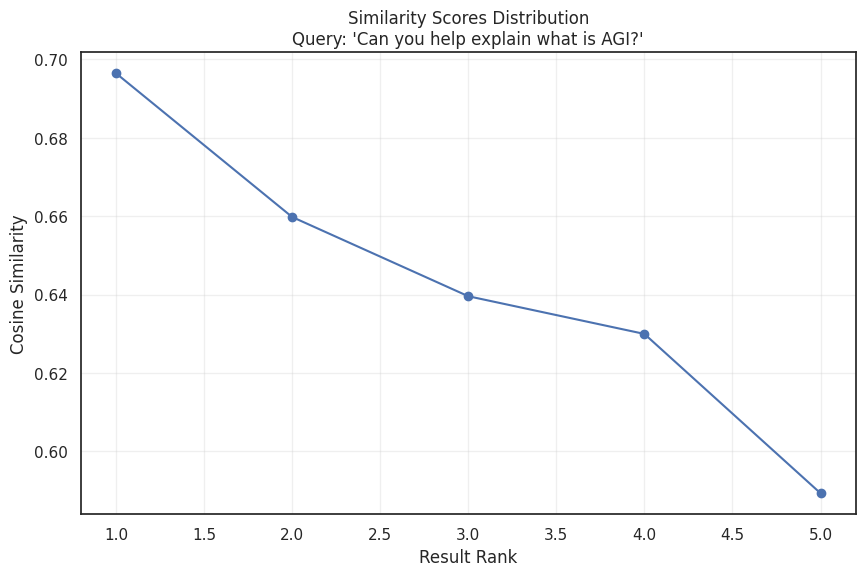

In [ ]:
# Initialize analyzer
analyzer = ChunkAnalyzer("semantic_transformer_chunks_english")

# Single query search
query = "Can you help explain what is AGI?"
results = analyzer.search_chunks(query, k=5)

# Print results
analyzer.print_search_results(results)

# # Plot similarity distribution
analyzer.plot_similarity_distribution(results)

# Compare multiple queries
# test_queries = [
#     "What is AGI?",
#     "Does AGI controls itself?",
#     "How will AGI create an impact?"
# ]
# comparison_df = analyzer.analyze_multiple_queries(test_queries)
# print("\nQuery Comparison:")
# print(comparison_df)

#### Sequential Semantic Chunking

In [ ]:
import re
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


def split_hindi_text(text: str) -> list:
    """
    Split Hindi text into sentences using regex and return a list of chunks with indices.

    Args:
        text (str): The input Hindi text to split.

    Returns:
        list: A list of dictionaries with `chunk` and `index` keys.
    """
    # Split sentences using the Danda punctuation (।) for Hindi
    sentences = [
        sentence.strip()
        for sentence in re.split(r"(?<=[।])\s*", text)
        if sentence.strip()
    ]

    # Create chunks with indices
    initial_chunks = [
        {"chunk": sentence, "index": i} for i, sentence in enumerate(sentences)
    ]

    return initial_chunks


# Step 1: Split text into sentences
def split_text_into_chunks(text: str) -> list:
    sentences = re.split(
        r"(?<=[.?!])\s+", text
    )  # we can experiment with different sentence splitting models here.

    print("Splitting Sentences")
    initial_chunks = [
        {"chunk": sentence, "index": i} for i, sentence in enumerate(sentences)
    ]
    sentences = [chunk["chunk"] for chunk in initial_chunks]

    if len(sentences) < 3:
        print("Assuming and splitting hindi text into sentences ")
        sentences = [
            sentence.strip()
            for sentence in re.split(r"(?<=[।])\s*", text)
            if sentence.strip()
        ]

    initial_chunks = [
        {"chunk": sentence, "index": i} for i, sentence in enumerate(sentences)
    ]

    return initial_chunks


# Step 2: Combine neighboring chunks
def combine_chunks(chunks: list) -> list:
    for i in range(len(chunks)):
        combined_chunk = ""

        if i > 0:
            combined_chunk += chunks[i - 1]["chunk"]

        combined_chunk += chunks[i]["chunk"]

        if i < len(chunks) - 1:
            combined_chunk += chunks[i + 1]["chunk"]

        chunks[i]["combined_chunk"] = combined_chunk

    return chunks

In [ ]:
# Step 3: Add embeddings to chunks
def add_embeddings_to_chunks(model, chunks: list) -> list:
    combined_chunks_text = [chunk["combined_chunk"] for chunk in chunks]
    chunk_embeddings = model.encode(combined_chunks_text, show_progress_bar=True)

    for i, chunk in enumerate(chunks):
        chunk["embedding"] = chunk_embeddings[i]

    return chunks

In [ ]:
# Step 4: Calculate cosine distances between consecutive embeddings
def calculate_cosine_distances(chunks: list) -> list:
    distances = []
    for i in range(len(chunks) - 1):
        current_embedding = chunks[i]["embedding"]
        next_embedding = chunks[i + 1]["embedding"]

        similarity = cosine_similarity([current_embedding], [next_embedding])[0][0]
        distance = 1 - similarity

        distances.append(distance)
        chunks[i]["distance_to_next"] = distance

    return distances

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Step 5: Visualize distances with thresholds
def visualize_cosine_distances_with_thresholds(
    cosine_distances: list, threshold_percentile: int = 90
) -> list:
    # Calculate the threshold value based on the percentile
    threshold_value = np.percentile(cosine_distances, threshold_percentile)

    # Identify the crossing points
    crossing_points = [0]
    crossing_points += [
        i for i, distance in enumerate(cosine_distances) if distance > threshold_value
    ]
    crossing_points.append(len(cosine_distances))

    # Plot the distances and highlight threshold crossings
    plt.figure(figsize=(14, 6))
    sns.set(style="white")
    sns.lineplot(
        x=range(len(cosine_distances)),
        y=cosine_distances,
        color="blue",
        label="Cosine Distance",
    )

    plt.axhline(
        y=threshold_value,
        color="red",
        linestyle="--",
        label=f"{threshold_percentile}th Percentile Threshold",
    )

    colors = sns.color_palette("hsv", len(crossing_points) - 1)
    for i in range(len(crossing_points) - 1):
        plt.axvspan(
            crossing_points[i], crossing_points[i + 1], color=colors[i], alpha=0.3
        )

    plt.title("Cosine Distances Between Segments with Threshold Highlighting")
    plt.xlabel("Segment Index")
    plt.ylabel("Cosine Distance")
    plt.legend()
    plt.show()

    return crossing_points

In [ ]:
def create_final_chunks(sentences: list, crossing_points: list) -> list:
    """
    Combine sentences into final chunks based on crossing points.

    Args:
        sentences: List of original sentences.
        crossing_points: List of indices indicating chunk boundaries.

    Returns:
        List of final chunks as strings.
    """
    final_chunks = []
    for i in range(len(crossing_points) - 1):
        start = crossing_points[i]
        end = crossing_points[i + 1]
        chunk = " ".join(sentences[start:end])
        final_chunks.append(chunk)
    return final_chunks

80


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

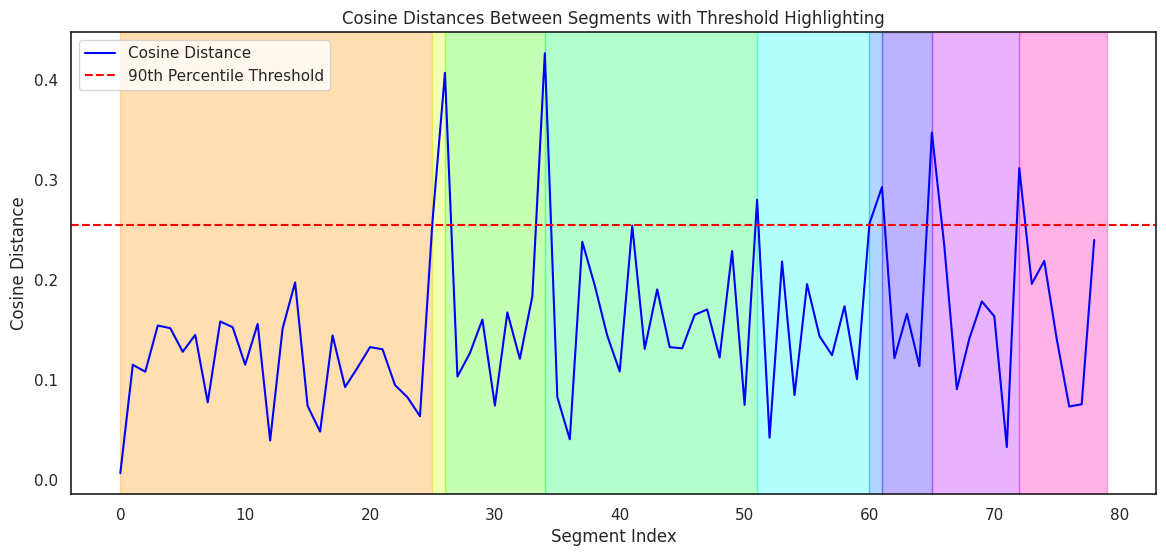

Crossing Points: [0, 25, 26, 34, 51, 60, 61, 65, 72, 79]
Final Chunks:
Lenght : 3763,Chunk 1: कृत्रिम सामान्य बुद्धिमत्ता (AGI) उस प्रकार की एआई को संदर्भित करती है जो किसी भी बौद्धिक कार्य को करने में सक्षम हो, जो एक मानव कर सकता है। संकीर्ण एआई के विपरीत, जिसे विशिष्ट कार्यों के लिए डिज़ाइन किया गया है जैसे कि भाषा अनुवाद या छवि पहचान, AGI का लक्ष्य मानव
संज्ञानात्मक क्षमताओं को पुनः उत्पन्न करना है जैसे कि तर्क, शिक्षा, और समस्या समाधान। AGI का विकास एआई के क्षेत्र में सबसे
बड़े चुनौतियों में से एक माना जाता है, क्योंकि इसमें मानव मस्तिष्क की जटिलता को समझने और अनुकरण करने की आवश्यकता होती है। AGI उद्योगों को क्रांतिकारी रूप से बदल सकता है, जैसे कि स्वास्थ्य देखभाल, शिक्षा, स्वचालन और शोध। हालांकि, यह नैतिकता, नियंत्रण
और संभावित दुरुपयोग के बारे में चिंता भी पैदा करता है। AGI की खोज में शोधकर्ताओं को कई तकनीकी कठिनाइयों का सामना करना पड़ता है, जिनमें मशीनों का विकास करना शामिल है जो संदर्भ को
समझ सके, सामान्य ज्ञान लागू कर सके, और रचनात्मकता प्रदर्शित कर सके। जबकि वर्तमान एआई प्रणा

In [ ]:
# using above functions now.
# wow. use this function now and see how different laguages have different crossing point of threshold and giving different chunks than expected.
# this approach sounds good but definitely require more consideration of embedding models we are using because it'll impact the final result.
# write about different behaviours in the blog.

text = hindi_text

model = initialize_model_and_nltk()
# Step 1: Split text into chunks

# chunks = split_text_into_chunks(text)
chunks = split_hindi_text(text)


sentences = [chunk["chunk"] for chunk in chunks]
print(len(sentences))

# Step 2: Combine chunks
combined_chunks = combine_chunks(chunks)

# Step 3: Add embeddings to chunks
embedded_chunks = add_embeddings_to_chunks(model, combined_chunks)

# Step 4: Calculate cosine distances
distances = calculate_cosine_distances(embedded_chunks)

# Step 5: Visualize distances and get crossing points
crossing_points = visualize_cosine_distances_with_thresholds(
    distances, threshold_percentile=90
)

final_chunks = create_final_chunks(sentences, crossing_points)
print("Crossing Points:", crossing_points)


# also talk about how chunk lenght changes now.
# View the final chunked results
print("Final Chunks:")
for i, chunk in enumerate(final_chunks, 1):
    print(f"Lenght : {len(chunk)},Chunk {i}: {chunk}")
    print("\n\n")

Chunk Statistics:
Total Chunks: 10
Mean Length: 1248.10
Median Length: 766.5
Standard Deviation: 1352.17
Variance: 1828365.69
Minimum Length: 174
Maximum Length: 4852
Range of Lengths: 4678


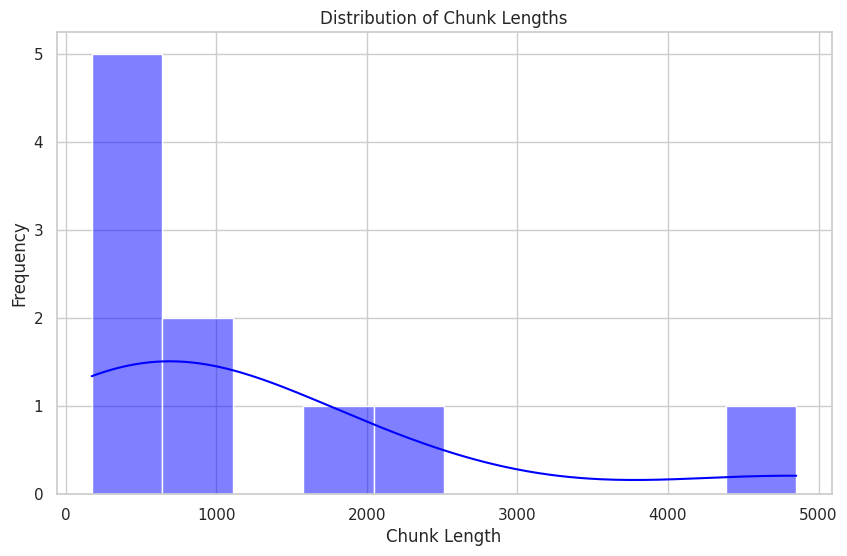

In [ ]:
import numpy as np

# Collect lengths of chunks
chunk_lengths = [len(chunk) for chunk in final_chunks]

# Calculate basic statistics
mean_length = np.mean(chunk_lengths)
median_length = np.median(chunk_lengths)
std_dev_length = np.std(chunk_lengths)
variance_length = np.var(chunk_lengths)
min_length = np.min(chunk_lengths)
max_length = np.max(chunk_lengths)
range_length = max_length - min_length

# Display the statistics
print("Chunk Statistics:")
print(f"Total Chunks: {len(chunk_lengths)}")
print(f"Mean Length: {mean_length:.2f}")
print(f"Median Length: {median_length}")
print(f"Standard Deviation: {std_dev_length:.2f}")
print(f"Variance: {variance_length:.2f}")
print(f"Minimum Length: {min_length}")
print(f"Maximum Length: {max_length}")
print(f"Range of Lengths: {range_length}")

# Visualize the distribution
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(chunk_lengths, bins=10, kde=True, color="blue")
plt.title("Distribution of Chunk Lengths")
plt.xlabel("Chunk Length")
plt.ylabel("Frequency")
plt.show()

#### Creating Propositions

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import PromptTemplate
from langchain.output_parsers import CommaSeparatedListOutputParser
from typing import List
import google.generativeai as genai
from tqdm import tqdm
from langchain import hub
from langchain.pydantic_v1 import BaseModel


def initialize_gemini(api_key: str) -> ChatGoogleGenerativeAI:
    """Initialize Gemini model"""
    genai.configure(api_key=api_key)
    return ChatGoogleGenerativeAI(api_key=api_key, model="gemini-pro", temperature=0)


def get_proposition_prompt(text: str) -> str:
    """Create prompt for proposition extraction"""

    template = """Extract the main propositions from the following text.
    A proposition is a single, atomic statement that expresses one main idea or fact.
    Break down complex sentences into simple, independent statements.
    Return the propositions as a comma-separated list.

    Text: {text}

    Propositions:"""

    prompt = PromptTemplate(input_variables=["text"], template=template)

    return prompt.format(text=text)


def create_propositions(text: str, llm: ChatGoogleGenerativeAI) -> List[str]:
    """Extract propositions from text using Gemini"""
    output_parser = CommaSeparatedListOutputParser()

    try:
        # Get propositions from Gemini
        prompt = get_proposition_prompt(text)
        # prompt = hub.pull("wfh/proposal-indexing")

        response = llm.invoke(prompt)

        response = (
            response.content
        )  # make sure you add .content since the response it AI message
        # Parse and clean propositions
        propositions = output_parser.parse(response)
        propositions = [p.strip() for p in propositions if p.strip()]
        return propositions

    except Exception as e:
        print(f"Error processing text: {e}")
        return []


def chunk_propositions(propositions: List[str], chunk_size: int = 1000) -> List[str]:
    """Combine propositions into chunks of specified size"""
    chunks = []
    current_chunk = []
    current_length = 0

    for prop in propositions:
        prop_length = len(prop)

        if current_length + prop_length > chunk_size:
            # Save current chunk and start new one
            if current_chunk:
                chunks.append(" ".join(current_chunk))
            current_chunk = [prop]
            current_length = prop_length
        else:
            current_chunk.append(prop)
            current_length += prop_length

    # Add final chunk
    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks


def analyze_propositions(propositions: List[str]) -> dict:
    """Analyze the extracted propositions"""
    lengths = [len(p) for p in propositions]

    return {
        "num_propositions": len(propositions),
        "avg_length": sum(lengths) / len(lengths) if lengths else 0,
        "min_length": min(lengths) if lengths else 0,
        "max_length": max(lengths) if lengths else 0,
        "propositions": propositions,
    }


def process_text(text: str, api_key: str, chunk_size: int = 1000) -> dict:
    """Process text end-to-end: create propositions, chunks, and analysis"""
    # Initialize Gemini
    llm = initialize_gemini(api_key)

    # Split into paragraphs
    paragraphs = [p.strip() for p in text.split("\n\n") if p.strip()]

    # Get propositions from each paragraph
    all_propositions = []
    for para in tqdm(paragraphs, desc="Processing paragraphs"):
        props = create_propositions(para, llm)
        all_propositions.extend(props)

    # Create chunks
    chunks = chunk_propositions(all_propositions, chunk_size)

    # Analyze propositions
    analysis = analyze_propositions(all_propositions)

    return {"chunks": chunks, "analysis": analysis}

In [ ]:
# Just create propositions


text = """Aman is a good guy. He recently met a boy named Akhil. They started playing chess.

aman liked chess. He plays chess at grandmaster level."""


llm = initialize_gemini(api_key)
# print(llm.invoke("hello"))


props = create_propositions(text, llm)

# Just create chunks from existing propositions
chunks = chunk_propositions(props, chunk_size=1000)

# Just analyze propositions
analysis = analyze_propositions(props)